<a href="https://colab.research.google.com/github/hyeonji-cho/Pytorch_Textbook/blob/main/ch6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.1.1 LeNet



### 필요한 라이브러리 호출

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm  # 진행 상황을 가시적으로 표현
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 데이터 불러오기

In [2]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap06/data/dogs-vs-cats.zip 데이터 불러오기

Saving dogs-vs-cats.zip to dogs-vs-cats.zip


In [3]:
!unzip dogs-vs-cats.zip -d dogs-vs-cats/  #dogs-vs-cats 폴더 만들어 압축 풀기

Archive:  dogs-vs-cats.zip
   creating: dogs-vs-cats/Cat/
  inflating: dogs-vs-cats/Cat/cat.0.jpg  
  inflating: dogs-vs-cats/Cat/cat.1.jpg  
  inflating: dogs-vs-cats/Cat/cat.10.jpg  
  inflating: dogs-vs-cats/Cat/cat.100.jpg  
  inflating: dogs-vs-cats/Cat/cat.101.jpg  
  inflating: dogs-vs-cats/Cat/cat.102.jpg  
  inflating: dogs-vs-cats/Cat/cat.103.jpg  
  inflating: dogs-vs-cats/Cat/cat.104.jpg  
  inflating: dogs-vs-cats/Cat/cat.105.jpg  
  inflating: dogs-vs-cats/Cat/cat.106.jpg  
  inflating: dogs-vs-cats/Cat/cat.107.jpg  
  inflating: dogs-vs-cats/Cat/cat.108.jpg  
  inflating: dogs-vs-cats/Cat/cat.109.jpg  
  inflating: dogs-vs-cats/Cat/cat.11.jpg  
  inflating: dogs-vs-cats/Cat/cat.110.jpg  
  inflating: dogs-vs-cats/Cat/cat.111.jpg  
  inflating: dogs-vs-cats/Cat/cat.112.jpg  
  inflating: dogs-vs-cats/Cat/cat.113.jpg  
  inflating: dogs-vs-cats/Cat/cat.114.jpg  
  inflating: dogs-vs-cats/Cat/cat.115.jpg  
  inflating: dogs-vs-cats/Cat/cat.116.jpg  
  inflating: dogs-vs-cat

### 이미지 데이터셋 전처리

In [4]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([  # 이미지를 변형할 수 있는 방식들의 묶음
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),  # 임의의 크기(50~100%)만큼 면적을 무작위로 자르겠다
                transforms.RandomHorizontalFlip(),  # 이미지를 수평 반전
                transforms.ToTensor(),  # 픽셀 값의 범위는 [0.0, 1.0] 사이이고 차원이 (채널수x높이x너비)로 바뀐다
                transforms.Normalize(mean, std)  # 채널별 평균과 표준편차에 맞는 정규화
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):  # 클래스를 호출할 수 있도록 하는 메서드
        return self.data_transform[phase](img)  # 클래스 객체 자체를 호출하면 리턴값이 반환된다

### 이미지 데이터셋을 불러온 후 훈련, 검증, 테스트로 분리

In [5]:
cat_directory = 'dogs-vs-cats/Cat/'
dog_directory = 'dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)]) # cat_directory에 있는 파일명과 경로를 합쳐 반환한다
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]  # 개와 고양이 이미지들을 합쳐서 images_filepaths에 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)  # 계속 동일한 난수 생성
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]  # 훈련용 400개 이미지
val_images_filepaths = correct_images_filepaths[400:-10]  # 검증용 92개 이미지
test_images_filepaths = correct_images_filepaths[-10:]  # 테스트용 10개 이미지
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


### 테스트 데이터셋 이미지 확인 함수

In [6]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):  # enumerate : 인덱스와 값을 리턴
        image = cv2.imread(image_filepath)  # 이미지 파일을 읽을 때 사용
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 이미지의 색상 변경 (입력이미지, BGR->RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]  # 경로명 정규화, /를 기준으로 분할하고 뒤에서 2번쨰 반환
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)  # ravel: 1차원으로 평탄화된 배열을 반환, 1차원 배열에서 인덱스 i에 해당하는 서브플롯에 접근
        ax.ravel()[i].set_title(predicted_label, color=color)  # predicted_label을 타이틀로 사용
        ax.ravel()[i].set_axis_off()  # 이미지의 축 제거
    plt.tight_layout()  # 이미지의 여백을 조정
    plt.show()

### 테스트 데이터셋 이미지를 출력

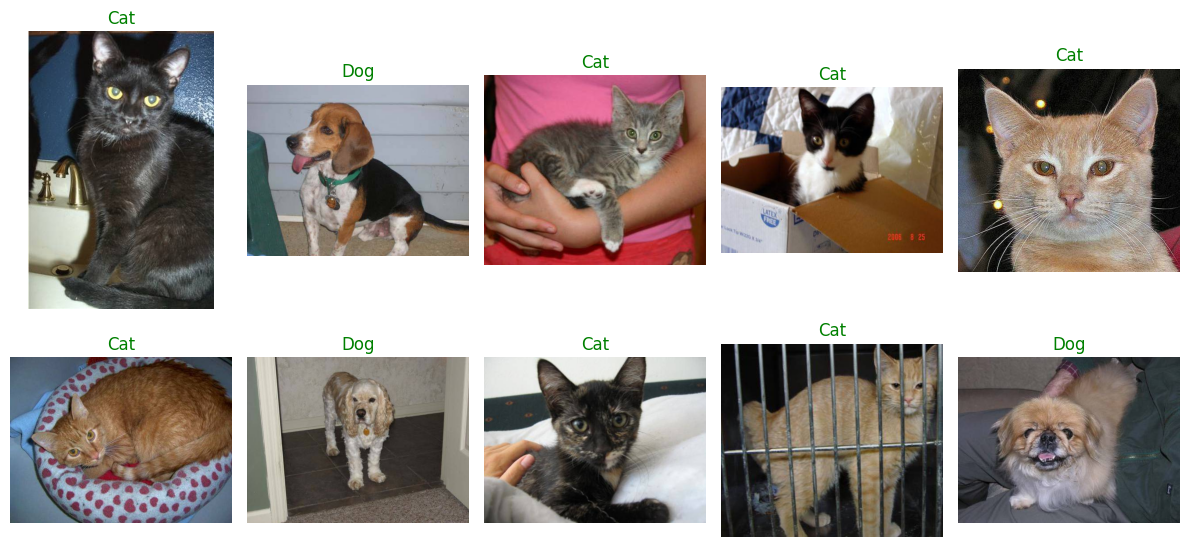

In [7]:
display_image_grid(test_images_filepaths)

### 이미지 데이터셋 클래스 정의

In [8]:
class DogvsCatDataset(Dataset):  # 데이터셋의 전처리
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 경로만 저장
        self.transform = transform  # DogvsCatDataset 클래스를 호출할 때 transform에 대한 매개변수를 받아온다
        self.phase = phase  # 'train' 적용

    def __len__(self):  # images_filepaths 데이터셋의 전체 길이를 반환
        return len(self.file_list)

    def __getitem__(self, idx):  # 데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태가 된다
        img_path = self.file_list[idx]
        img = Image.open(img_path)  # img_path 위치에서 이미지 데이터들을 가져온다
        img_transformed = self.transform(img, self.phase)  # 이미지에 'train'전처리를 적용

        label = img_path.split('/')[-1].split('.')[0]  # '/'제거, '.'제거
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

### 변수 값 정의

In [9]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

### 이미지 데이터셋 정의

In [10]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')  # 훈련 이미지에 train_transforms 적용
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')  # 검증 이미지에 test_transforms 적용

index = 0
print(train_dataset.__getitem__(index)[0].size())  # 훈련 데이터의 크기 출력
print(train_dataset.__getitem__(index)[1])  # 훈련 데이터의 레이블 출

torch.Size([3, 224, 224])
0


### 데이터로더 정의

- 데이터로더는 배치 관리를 담당한다
- 한 번에 모든 데이터를 불러오면 메모리에 부담을 줄 수 있기 때문에 데이터를 그룹으로 쪼개서 조금씩 불러온다

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 데이터셋, 한 번에 메모리로 불러올 데이터 크기, 섞어서
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}  # 훈련과 검증 데이터셋을 합쳐서 표현

batch_iterator = iter(train_dataloader)  # 이터레이터로 변환
inputs, label = next(batch_iterator)  # 다음 요소 반환 (공급될 데이터, 해당하는 레이)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 0])


### 모델의 네트워크 클래스

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) # (3, 224, 224)->(16, 220, 220)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # (16, 110, 110)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) # (32, 106, 106)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # (32, 53, 53)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) # 데이터를 1차원 형태로 전환
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

### 모델 객체 생성

In [13]:
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


### torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인

In [14]:
!pip install torchsummary

In [15]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

### 학습 가능한 파라미터 수 확인


In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


### 옵티마이저와 손실 함수 정의

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # 파라미터, 가중치를 변경할 때 얼마나 크게 변경할지, 적절한 방향으로 가속화하며 흔들림을 줄여준다
criterion = nn.CrossEntropyLoss()

### 모델의 파라미터와 손실 함수를 CPU에 할당

In [18]:
model = model.to(device)
criterion = criterion.to(device)

### 모델 학습 함수 정의

In [19]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):  # epoch만큼 반복
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델 학습
            else:
                model.eval()  # 모델 평가

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):  # dataloader_dict : 훈련 데이터셋
                inputs = inputs.to(device)  # 훈련 데이터셋을 CPU에 할당
                labels = labels.to(device)
                optimizer.zero_grad()  # 역전파 단계를 실행하기 전에 기울기를 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'):  # train인 경우에만 gradient 계산을 활성화
                    outputs = model(inputs)  # 입력 데이터를 모델에 전달하여 예측을 얻음
                    _, preds = torch.max(outputs, 1)  # 최대값을 갖는 클래스의 인덱스를 찾음
                    loss = criterion(outputs, labels)  # 손실 함수를 이용한 오차 계산

                    if phase == 'train':
                        loss.backward()  # 역전파 수행
                        optimizer.step()  # 옵티마이저를 사용하여 모델의 파라미터 업데이트

                    epoch_loss += loss.item() * inputs.size(0)  # 현재 배치의 손실 * 해당 배치의 크기
                    epoch_corrects += torch.sum(preds == labels.data)  # 현재 배치에서 정확한 예측의 수

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)  # 최종 오차 계산 (오차/데이터셋의 길이)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)  # 최종 정확도 (epoch_corrects/데이터셋의 길이)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:  # 검증 데이터셋에 대한 가장 최적의 정확도를 저장
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

### 모델 학습

In [20]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-19-ca1341bfa09e>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):  # dataloader_dict : 훈련 데이터셋


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6939 Acc: 0.4750


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6944 Acc: 0.5217
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6868 Acc: 0.5800


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7000 Acc: 0.4783
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6826 Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6946 Acc: 0.5652
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6851 Acc: 0.5775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6901 Acc: 0.5652
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6762 Acc: 0.5925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6911 Acc: 0.5217
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6669 Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6914 Acc: 0.5326
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6640 Acc: 0.6250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6974 Acc: 0.5435
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6770 Acc: 0.5675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6990 Acc: 0.5652
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6644 Acc: 0.6075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6889 Acc: 0.5543
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6566 Acc: 0.6275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5326
Training complete in 0m 34s
Best val Acc: 0.565217


### 모델 테스트를 위한 함수 정의

In [21]:
import pandas as pd

id_list = []  # 각 이미지에 대한 ID 저장
pred_list = []  # 각 이미지에 대한 모델의 예측값 저장
_id=0
with torch.no_grad():  # 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음. 예측만 수행하고 파라미터가 바뀌지 않음
    for test_path in tqdm(test_images_filepaths):  # 테스트 데이터셋 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')  # 테스트 데이터셋 전처리 적용
        img = img.unsqueeze(0)  # 텐서에 차원을 추가
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()  # 텐서의 요소가 (0,1) 범위에 있고 합계가 1, 모든 행에서 두번째 칼럼(각 이미지에 대한 레이블 예측 확률)을 가져온다, 리스트 형태로 반환
        id_list.append(_id)  # 각 이미지의 ID를 리스트에 추가
        pred_list.append(preds[0])  # 각 이미지의 예측된 레이블 확률을 리스트에 추가

res = pd.DataFrame({  # 테스트 데이터셋의 예측 결과인 id와 label을 데이터 프레임에 저장
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)  # id열을 기준으로 정렬, 원본 데이터프레임을 변경하도록 지정
res.reset_index(drop=True, inplace=True)  # 데이터프레임의 인덱스를 재설정, 원본 데이터프레임을 변경하도록 지정

res.to_csv('LesNet.csv', index=False)  # 데이터 프레임을 CSV 파일로 저장

<ipython-input-21-e35ca1746438>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):  # 테스트 데이터셋 이용


  0%|          | 0/10 [00:00<?, ?it/s]

### 테스트 데이터셋의 예측 결과 호출

In [22]:
res.head(10)  # 데이터프레임에서 10개의 값을 보여준다

,id,label
0,109,0.361601
1,145,0.351111
2,15,0.479471
3,162,0.424442
4,167,0.477871
5,200,0.351180
6,210,0.463219
7,211,0.449764
8,213,0.421471
9,224,0.479740


### 테스트 데이터셋 이미지를 출력하기 위한 함수 정의

In [23]:
class_ = classes = {0:'cat', 1:'dog'}  # 개와 고양이에 대한 클래스 정의
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR형식 -> RGB형식

        a = random.choice(res['id'].values)  # 데이터프레임의 id라는 칼럼에서 임의로 데이터를 가져옴
        label = res.loc[res['id'] == a, 'label'].values[0]  # id열이 선택된 ID와 일치하는 행을 선택하고, 이 행에서 label열의 값을 가져온다
        if label > 0.5:  # 레이블 값이 0.5보다 크다면 개
            label = 1
        else:  # 레이블 값이 0.5보다 작으면 고양이
            label = 0
        ax.ravel()[i].imshow(image)  # ax.ravel():다차원 배열을 1차원으로 펴줌
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()  # 서브플롯 간의 간격을 최적화
    plt.show()

### 테스트 데이터셋 예측 결과 이미지 출력

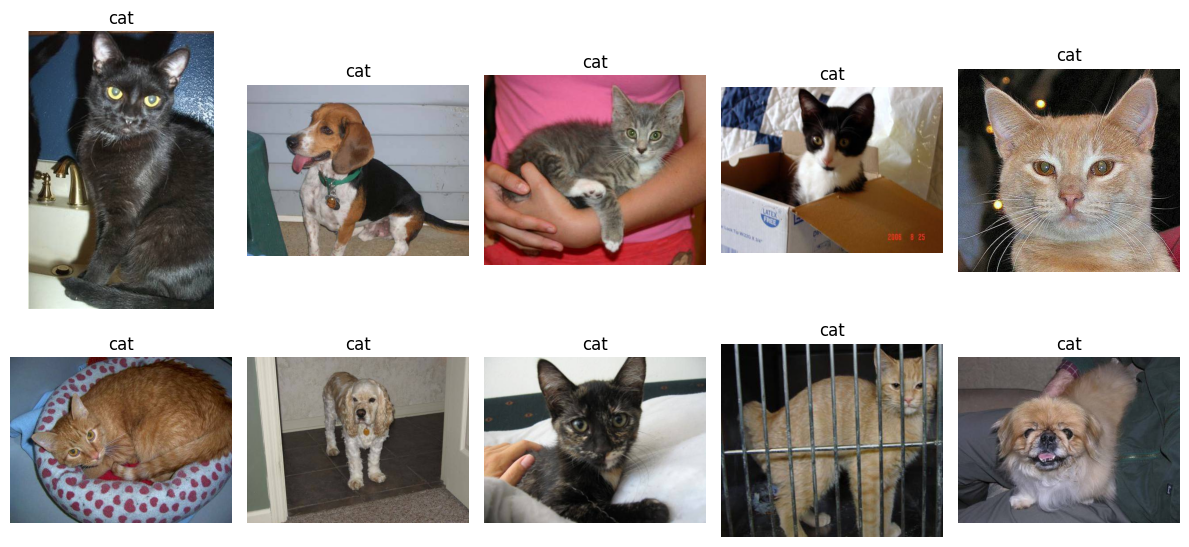

In [24]:
display_image_grid(test_images_filepaths)